# Library

In [171]:
# Librerie standard
import os
import random
import time
import re
import shutil
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice
from concurrent.futures import ProcessPoolExecutor
import warnings

# Librerie per il trattamento delle immagini
import cv2
import imageio.v3 as imageio
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patches
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score


# Librerie per il machine learning e deep learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torchvision.ops.boxes import box_iou
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as TF
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Librerie per la gestione dei dati
import pandas as pd
import json
#import orjson
import ast

# Librerie per il progresso e il monitoraggio
from tqdm import tqdm

# Librerie per il deep learning avanzato
from torch.amp import GradScaler, autocast
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights

import copy
import seaborn as sns

# Path

In [164]:
COCO_JSON_NM = 'COCO_annotations_new.json' 
OUT_COCO_JSON_NM = 'mod_COCO_annotations_new.json'
OUT_IMAGE_FLDR_NM = 'images'
RANDOM_SEED = 2023

in_dataset_pth = Path('/kaggle/input/our-xview-dataset')
out_dataset_pth = Path('/kaggle/working/')
img_fldr = Path(f'/kaggle/input/our-xview-dataset/{OUT_IMAGE_FLDR_NM}')

coco_json_pth = in_dataset_pth / COCO_JSON_NM
new_coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM

train_path = '/kaggle/working/train.json'
test_path = '/kaggle/working/test.json'
val_path = '/kaggle/working/val.json'

model_path = "/kaggle/input/faster-rcnn/pytorch/default/1/model_epoch_9.pth"

random.seed(RANDOM_SEED)

In [98]:
# Pulizia dell'output per cartelle specifiche
def clean_output(output_dir):
    if output_dir.exists() and output_dir.is_dir():
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)  # Rimuove la sotto-cartella
            else:
                item.unlink()  # Rimuove il file
        print(f"Cartella {output_dir} pulita.")
    else:
        print(f"Cartella {output_dir} non trovata. Nessuna azione necessaria.")

# Pulisce la cartella di output prima di avviare il processo
clean_output(out_dataset_pth)

Cartella /kaggle/working pulita.


In [99]:
# Sopprime i warning specifici del modulo skimage
warnings.filterwarnings("ignore", 
    message="Applying `local_binary_pattern` to floating-point images may give unexpected results.*")

# Utility

In [100]:
def load_json(file_path):
    """
    Carica un file JSON dal percorso specificato.

    :param file_path: Percorso al file JSON da caricare.
    :return: Dati contenuti nel file JSON (come dizionario o lista).
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [101]:
def random_filename(json_path):
    data = load_json(json_path)
    filenames = {img['file_name'] for img in data.get("images", [])}
    
    # Convertire il set in una lista per evitare il DeprecationWarning
    random_filenames = random.sample(list(filenames), min(2, len(filenames)))
    return random_filenames

In [102]:
def display_images_with_bboxes(json_file, specific_images, images_folder, mode = 2):
    """
    Visualizza le immagini specificate con tutti i bounding box sopra di esse.

    :param json_file: percorso del file JSON contenente le immagini, annotazioni e categorie
    :param specific_images: lista di nomi delle immagini da visualizzare
    :param images_folder: percorso della cartella che contiene le immagini
    """
    # Carica il JSON
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Estrai le immagini e le annotazioni
    images = data["images"]
    annotations = data["annotations"]

    # Crea un dizionario per mappare l'id delle immagini al nome del file
    image_dict = {image["id"]: image["file_name"] for image in images}

    # Filtra le annotazioni per le immagini specifiche
    specific_annotations = [ann for ann in annotations if image_dict[ann["image_id"]] in specific_images]

    # Creiamo un dizionario per raccogliere tutte le annotazioni per ciascuna immagine
    image_bboxes = {}
    for annotation in specific_annotations:
        image_name = image_dict[annotation["image_id"]]
        if image_name not in image_bboxes:
            image_bboxes[image_name] = []
        if mode == 1:
            bbox = ast.literal_eval(annotation["bbox"])
        else:
            bbox = annotation["bbox"]
        category_id = annotation["category_id"]
        image_bboxes[image_name].append((bbox, category_id))

    # Visualizza tutte le immagini con tutti i bounding box
    for image_name, bboxes in image_bboxes.items():
        # Carica l'immagine
        image_path = f'{images_folder}/{image_name}'  # Usa il percorso corretto per le immagini
        image = Image.open(image_path)

        # Crea la figura per la visualizzazione
        plt.figure(figsize=(8, 8))
        plt.imshow(image)

        # Aggiungi tutti i bounding box e il category_id
        if mode == 1:
            for bbox, category_id in bboxes:
                x, y, w, h = bbox
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(x, y - 5, f'Category: {category_id}', color='red', fontsize=10, backgroundcolor='white')
        else:
            for bbox, category_id in bboxes:
                x, y, x2, y2 = bbox
                w = x2 - x
                h = y2 - y
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(x, y - 5, f'Category: {category_id}', color='red', fontsize=10, backgroundcolor='white')

        # Imposta il titolo e disattiva gli assi
        plt.title(f"Image: {image_name}")
        plt.axis('off')
        plt.show()

In [103]:
def display_images_with_bboxes_dataloader(dataloader, num_images=4):
    """
    Visualizza un batch di immagini con i relativi bounding box in un layout 2x2.

    :param dataloader: il DataLoader che fornisce i dati (immagini, annotazioni)
    :param num_images: numero di immagini da visualizzare
    """
    # Ottieni il primo batch di dati dal dataloader
    images, targets = next(iter(dataloader))
    
    # Limita il numero di immagini da visualizzare
    images = images[:num_images]
    targets = targets[:num_images]
    
    # Imposta la figura con 2 righe e 2 colonne
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()  # Converte l'array 2D di assi in 1D per un facile accesso

    for i in range(len(images)):
        image_tensor = images[i]
        target = targets[i]

        # Converti il tensore dell'immagine in un formato visualizzabile
        image = image_tensor.permute(1, 2, 0).numpy()  # Cambia la dimensione da (C, H, W) a (H, W, C)
        image = np.clip(image, 0, 1)  # Garantisce che i valori siano nel range [0, 1]
        
        # Seleziona l'asse corrispondente per la visualizzazione
        ax = axes[i]
        ax.imshow(image)

        # Aggiungi tutti i bounding box
        bboxes = target['boxes']
        labels = target['labels']
        
        for j in range(len(bboxes)):
            bbox = bboxes[j].numpy()
            category_id = labels[j].item()
            
            x, y, x2, y2 = bbox
            w = x2 - x
            h = y2 - y
            ax.add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
            ax.text(x, y - 5, f'Category: {category_id}', color='red', fontsize=10, backgroundcolor='white')

        # Imposta il titolo per ogni immagine
        ax.set_title(f"Image {i + 1}")
        ax.axis('off')

    plt.tight_layout()  # Migliora la disposizione delle sottotrame
    plt.show()

In [104]:
def extract_categories_from_coco_json(json_path):
    """
    Estrae i nomi delle categorie da un file JSON in formato COCO, ordinandoli in base all'ID.

    Args:
        json_path (str): Path del file JSON COCO.

    Returns:
        list: Lista di nomi delle categorie ordinati per ID.
    """
    # Leggi il file JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni e ordina le categorie in base all'ID
    categories = sorted(data.get('categories', []), key=lambda x: x['id'])
    
    # Estrai solo i nomi delle categorie
    category_names = [cat["name"] for cat in categories]
    
    return category_names

In [105]:
def plot_category_distribution(json_path):
    # Carica il JSON
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    # Estrai le annotazioni
    annotations = data['annotations']
    
    # Conta le occorrenze delle categorie
    category_counts = Counter(item['category_id'] for item in annotations)
    
    # Prepara i dati per il grafico
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    
    # Crea il grafico
    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Category ID')
    plt.ylabel('Frequency')
    plt.title('Distribuzione delle categorie nel dataset')
    plt.xticks(categories)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Dataset Preprocessing

In [106]:
def process_custom_coco_json(input_path, output_path):
    """
    Funzione per processare un JSON COCO in formato personalizzato.
    """
    # Leggi il JSON dal file di input
    data = load_json(input_path)

    # Ottieni e correggi il formato delle categorie
    raw_categories = data.get('categories', [])
    categories = []
 
    for category in tqdm(raw_categories, desc="Processing Categories"):
        for id_str, name in category.items():
            try:
                categories.append({"id": int(id_str), "name": name})
            except ValueError:
                print(f"Errore nel parsing della categoria: {category}")

    # Trova la categoria "Aircraft" con ID 0
    aircraft_category = next((cat for cat in categories if cat['id'] == 0 and cat['name'] == "Aircraft"), None)
    if aircraft_category:
        aircraft_category['id'] = 11  # Cambia l'ID della categoria "Aircraft" a 11
        
    # Aggiungi la categoria "background" con ID 0 se non esiste
    if not any(cat['id'] == 0 for cat in categories):
        categories.append({"id": 0, "name": "background"})
 
    # Preprocessa le annotazioni in un dizionario per immagini
    image_annotations_dict = {}
    for annotation in tqdm(data.get('annotations', []), desc="Building Image Annotations Dictionary"):
        image_id = annotation['image_id']
        if image_id not in image_annotations_dict:
            image_annotations_dict[image_id] = []
        image_annotations_dict[image_id].append(annotation)
 
    # Elenco di annotazioni da mantenere (solo quelle valide)
    valid_annotations = []
    annotations_to_remove = set()
 
    # Controllo dei bounding box
    for annotation in tqdm(data.get('annotations', []), desc="Processing Annotations"):
        if annotation['category_id'] == 0:  # Se è Aircraft
            annotation['category_id'] = 11
        
        # Converte il formato del bbox
        if isinstance(annotation['bbox'], str):
            annotation['bbox'] = json.loads(annotation['bbox'])
        
        x, y, width, height = annotation['bbox']
        xmin, xmax = x, x + width
        ymin, ymax = y, y + height
        
        # Verifica che xmin < xmax e ymin < ymax, e che la larghezza e altezza siano sufficienti
        if xmin >= xmax or ymin >= ymax or width <= 10 or height <= 10:
            annotations_to_remove.add(annotation['id'])
        else:
            annotation['bbox'] = [xmin, ymin, xmax, ymax]
            valid_annotations.append(annotation)
 
    # Rimuovi le annotazioni non valide
    data['annotations'] = valid_annotations
 
    # Aggiorna le categorie nel JSON
    data['categories'] = categories

    # Seleziona casualmente il 10% delle immagini
    all_images = data.get('images', [])
    selected_images = random.sample(all_images, len(all_images) // 10)
    selected_image_ids = {img['id'] for img in selected_images}

    # Filtra immagini e annotazioni
    data['images'] = selected_images
    data['annotations'] = [ann for ann in data['annotations'] if ann['image_id'] in selected_image_ids]
 
    # Scrivi il JSON modificato nel file di output
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)

In [107]:
process_custom_coco_json(coco_json_pth, new_coco_json_pth)

Processing Annotations: 100%|██████████| 669983/669983 [00:03<00:00, 193111.64it/s]


In [108]:
old_json = load_json(coco_json_pth)

In [109]:
# Conta il numero di immagini, annotazioni e categorie
num_images = len(old_json.get("images", []))
num_annotations = len(old_json.get("annotations", []))
num_categories = len(old_json.get("categories", []))

print(f"Numero di immagini: {num_images}")
print(f"Numero di annotazioni: {num_annotations}")
print(f"Numero di categorie: {num_categories}")

Numero di immagini: 45891
Numero di annotazioni: 669983
Numero di categorie: 11


In [110]:
new_json = load_json(new_coco_json_pth)

In [111]:
# Conta il numero di immagini, annotazioni e categorie
num_images = len(new_json.get("images", []))
num_annotations = len(new_json.get("annotations", []))
num_categories = len(new_json.get("categories", []))

print(f"Numero di immagini: {num_images}")
print(f"Numero di annotazioni: {num_annotations}")
print(f"Numero di categorie: {num_categories}")

Numero di immagini: 4589
Numero di annotazioni: 50416
Numero di categorie: 12


In [112]:
def get_common_random_filenames(json_file1, json_file2):
    # Carica i file JSON
    with open(json_file1, 'r') as f1, open(json_file2, 'r') as f2:
        data1 = json.load(f1)
        data2 = json.load(f2)
    
    # Estrai i file name da entrambi i JSON
    filenames1 = {img['file_name'] for img in data1.get("images", [])}
    filenames2 = {img['file_name'] for img in data2.get("images", [])}
    
    # Trova i file name comuni
    common_filenames = list(filenames1 & filenames2)
    
    random_filenames = random.sample(common_filenames, min(2, len(common_filenames)))
    
    return random_filenames

OLD JSON


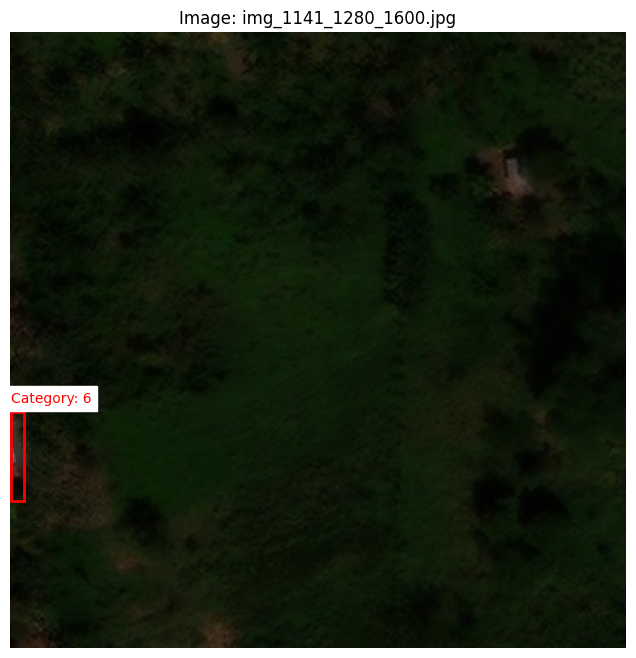

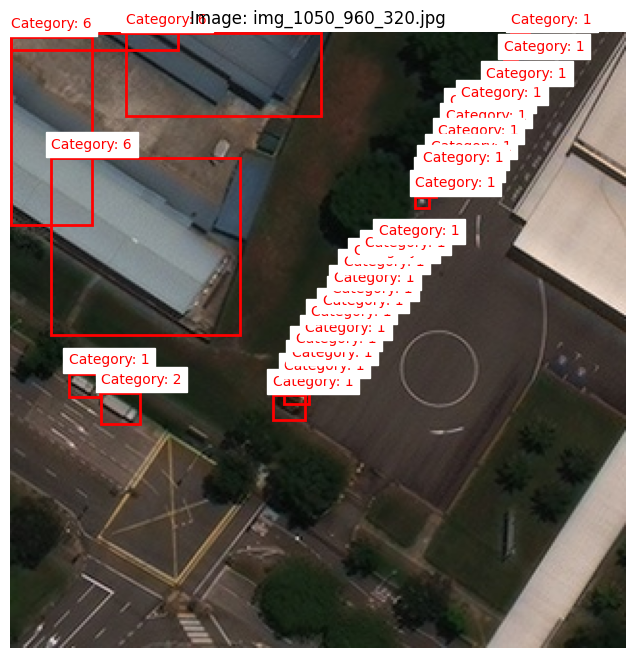

NEW JSON


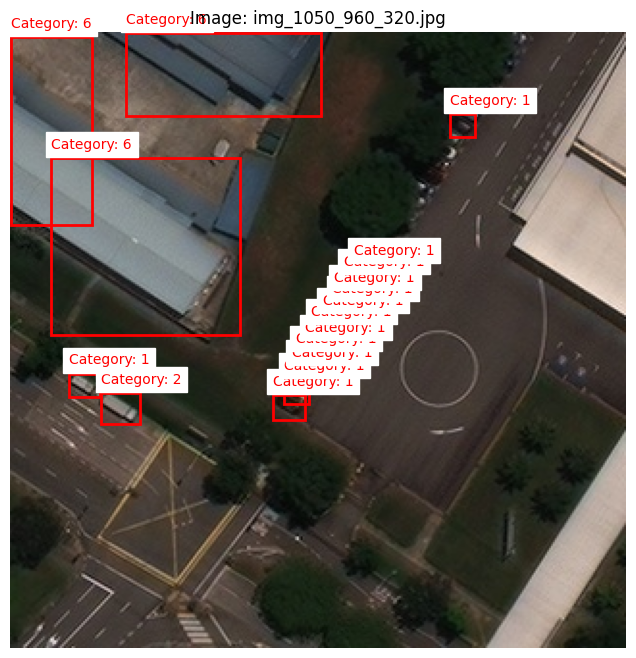

In [113]:
common_random_files = get_common_random_filenames(coco_json_pth, new_coco_json_pth)
print("OLD JSON")
display_images_with_bboxes(coco_json_pth, common_random_files, img_fldr, mode = 1)
print("NEW JSON")
display_images_with_bboxes(new_coco_json_pth, common_random_files, img_fldr)

# Undersampling e Upsampling

In [114]:
def count_bboxes_per_category(json_path):
    """
    Funzione che conta il numero di bounding box per ciascuna categoria in un file JSON formato COCO.
    
    :param json_path: Percorso al file JSON.
    :return: Dizionario con i nomi delle categorie come chiavi e il conteggio dei bounding box come valori.
    """
    # Leggi il JSON dal file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni mapping delle categorie (id -> nome)
    category_mapping = {cat['id']: cat['name'] for cat in data.get('categories', [])}
    
    # Conta i bounding box per ciascun category_id
    bbox_counts = defaultdict(int)
    for annotation in data.get('annotations', []):
        category_id = annotation['category_id']
        bbox_counts[category_id] += 1
    
    # Converti il conteggio usando i nomi delle categorie
    bbox_counts_named = {category_mapping[cat_id]: count for cat_id, count in bbox_counts.items()}

    return bbox_counts_named

In [115]:
bbox_counts = count_bboxes_per_category(new_coco_json_pth)

# Stampa i risultati
for category, count in bbox_counts.items():
    print(f"Categoria: {category}, Numero di bbox: {count}")

Categoria: Building, Numero di bbox: 35649
Categoria: Passenger Vehicle, Numero di bbox: 9748
Categoria: Truck, Numero di bbox: 2492
Categoria: Storage Tank, Numero di bbox: 229
Categoria: Engineering Vehicle, Numero di bbox: 478
Categoria: Railway Vehicle, Numero di bbox: 521
Categoria: Aircraft, Numero di bbox: 128
Categoria: Maritime Vessel, Numero di bbox: 638
Categoria: Shipping Container, Numero di bbox: 481
Categoria: Pylon, Numero di bbox: 33
Categoria: Helipad, Numero di bbox: 19


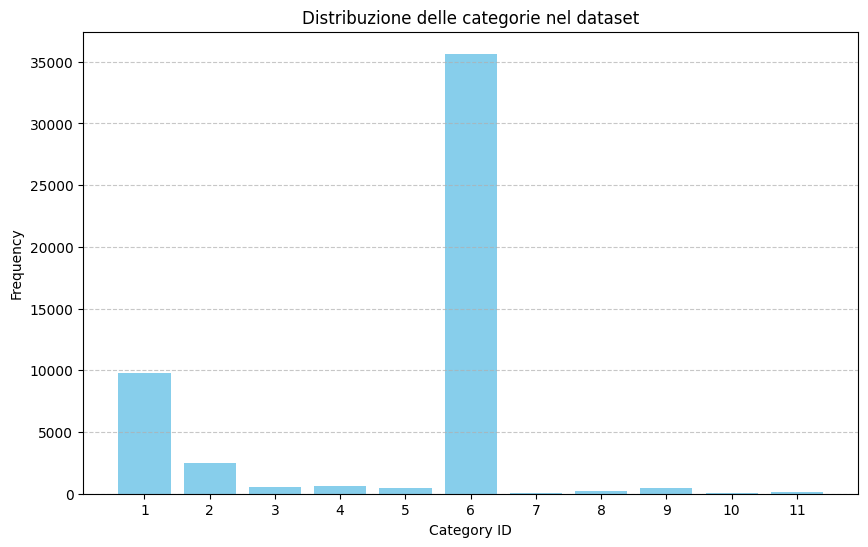

In [116]:
plot_category_distribution(new_coco_json_pth)

In [117]:
def undersample_class(json_data_path, dataset_out, target_class=6, target_percentage=0.9):
    # Carica il file JSON
    def load_json(file_path):
        with open(file_path, "r") as file:
            return json.load(file)

    json_data = load_json(json_data_path)
    
    # Conta le occorrenze delle classi per immagine
    image_class_counts = Counter()
    total_class_counts = Counter()
    for annotation in json_data["annotations"]:
        image_class_counts[(annotation["image_id"], annotation["category_id"])] += 1
        total_class_counts[annotation["image_id"]] += 1

    # Identifica immagini con almeno il 90% delle annotazioni nella classe target
    images_with_majority_target = {
        image_id for (image_id, category_id), count in image_class_counts.items()
        if category_id == target_class and count / total_class_counts[image_id] >= target_percentage
    }

    # Rimuovi immagini che contengono solo la classe target
    images_with_only_target = {
        image_id for (image_id, category_id), count in image_class_counts.items()
        if category_id == target_class and total_class_counts[image_id] == count
    }

    # Unione delle due condizioni: solo target o maggioranza target
    images_to_remove = images_with_majority_target | images_with_only_target

    # Filtra immagini e annotazioni per rimuovere quelle non necessarie
    remaining_images = [
        img for img in json_data["images"] 
        if img["id"] not in images_to_remove
    ]
    remaining_annotations = [
        ann for ann in json_data["annotations"] 
        if ann["image_id"] not in images_to_remove
    ]

    # Aggiorna il JSON
    json_data["images"] = remaining_images
    json_data["annotations"] = remaining_annotations

    # Salva il risultato in un nuovo file
    with open(dataset_out, "w") as file:
        json.dump(json_data, file, indent=4)

    print(f"Immagini processate e undersampling completato.")

In [118]:
undersample_class(new_coco_json_pth, new_coco_json_pth, target_class=6)

Immagini processate e undersampling completato.


In [119]:
new_json = load_json(new_coco_json_pth)

# Conta il numero di immagini, annotazioni e categorie
num_images = len(new_json.get("images", []))
num_annotations = len(new_json.get("annotations", []))
num_categories = len(new_json.get("categories", []))

print(f"Numero di immagini: {num_images}")
print(f"Numero di annotazioni: {num_annotations}")
print(f"Numero di categorie: {num_categories}")

Numero di immagini: 3304
Numero di annotazioni: 26422
Numero di categorie: 12


In [120]:
bbox_counts = count_bboxes_per_category(new_coco_json_pth)

# Stampa i risultati
for category, count in bbox_counts.items():
    print(f"Categoria: {category}, Numero di bbox: {count}")

Categoria: Passenger Vehicle, Numero di bbox: 9349
Categoria: Building, Numero di bbox: 12167
Categoria: Truck, Numero di bbox: 2416
Categoria: Storage Tank, Numero di bbox: 218
Categoria: Engineering Vehicle, Numero di bbox: 463
Categoria: Railway Vehicle, Numero di bbox: 517
Categoria: Aircraft, Numero di bbox: 127
Categoria: Maritime Vessel, Numero di bbox: 637
Categoria: Shipping Container, Numero di bbox: 478
Categoria: Pylon, Numero di bbox: 31
Categoria: Helipad, Numero di bbox: 19


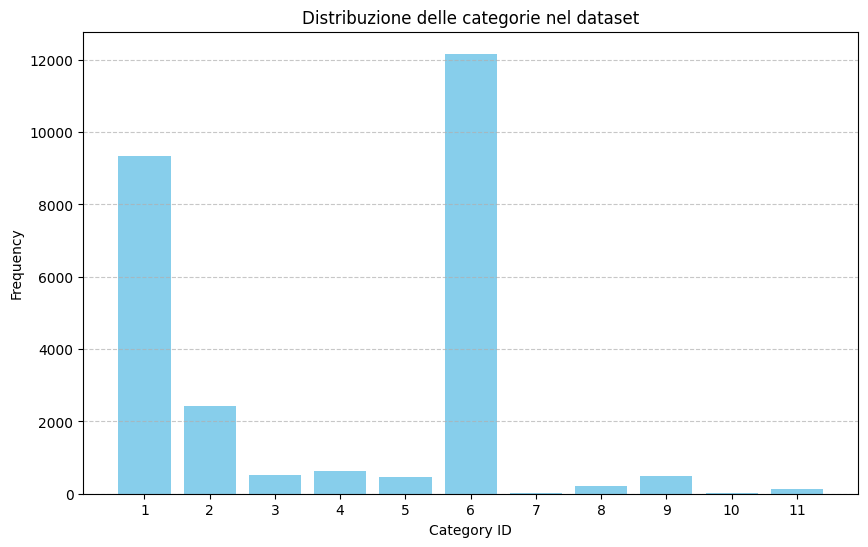

In [121]:
plot_category_distribution(new_coco_json_pth)

In [122]:
def upsample_classes(json_data_path, dataset_out, classes_to_upsample, value):
    json_data = load_json(json_data_path)

    # Conta le occorrenze attuali per ciascuna classe
    class_bbox_counts = Counter()
    image_annotations = {}

    for annotation in json_data["annotations"]:
        if annotation["category_id"] in classes_to_upsample:
            class_bbox_counts[annotation["category_id"]] += 1
        if annotation["image_id"] not in image_annotations:
            image_annotations[annotation["image_id"]] = []
        image_annotations[annotation["image_id"]].append(annotation)

    # Identifica immagini con priorità per ciascuna classe da upsamplare
    class_images = {class_id: [] for class_id in classes_to_upsample}
    for img in json_data["images"]:
        image_id = img["id"]
        annotations = image_annotations.get(image_id, [])
        target_annotations = [ann for ann in annotations if ann["category_id"] in classes_to_upsample]
        
        if target_annotations:
            # Classifica le immagini in base al numero di bbox della classe target
            for ann in target_annotations:
                class_images[ann["category_id"]].append((img, annotations))

    # Ordina le immagini per ciascuna classe in base al numero di bbox
    for class_id in classes_to_upsample:
        class_images[class_id].sort(key=lambda x: len([ann for ann in x[1] if ann["category_id"] == class_id]), reverse=True)

    # Crea nuove immagini e annotazioni per aumentare le occorrenze
    new_images = []
    new_annotations = []
    image_id_offset = max(img["id"] for img in json_data["images"]) + 1
    annotation_id_offset = max(ann["id"] for ann in json_data["annotations"]) + 1

    for class_id in classes_to_upsample:
        class_data = class_images[class_id]
        idx = 0
        current_count = class_bbox_counts[class_id]
        target_count = value * class_bbox_counts[class_id]

        while current_count < target_count:
            img, annotations = class_data[idx % len(class_data)]

            # Duplica l'immagine
            new_img = copy.deepcopy(img)
            new_img["id"] = image_id_offset

            # Duplica le annotazioni associate alla classe target
            for ann in annotations:
                if ann["category_id"] == class_id:
                    new_ann = copy.deepcopy(ann)
                    new_ann["id"] = annotation_id_offset
                    new_ann["image_id"] = image_id_offset
                    new_annotations.append(new_ann)
                    annotation_id_offset += 1

            new_images.append(new_img)

            # Incrementa gli offset e il conteggio
            image_id_offset += 1
            current_count += len([ann for ann in annotations if ann["category_id"] == class_id])
            idx += 1

    # Aggiungi le nuove immagini e annotazioni al JSON
    json_data["images"].extend(new_images)
    json_data["annotations"].extend(new_annotations)

    # Salva il risultato in un nuovo file
    with open(dataset_out, "w") as file:
        json.dump(json_data, file, indent=4)

    print(f"Upsampling completato.")

In [123]:
# Lista delle classi da fare upsampling e il numero target di occorrenze per ciascuna
classes_to_upsample = [2, 3, 4, 5, 7, 8, 9, 10, 11] 

# Chiamata alla funzione
upsample_classes(new_coco_json_pth, new_coco_json_pth, classes_to_upsample, value = 3)

Upsampling completato. Salvato in /kaggle/working/mod_COCO_annotations_new.json


In [124]:
new_json = load_json(new_coco_json_pth)

# Conta il numero di immagini, annotazioni e categorie
num_images = len(new_json.get("images", []))
num_annotations = len(new_json.get("annotations", []))
num_categories = len(new_json.get("categories", []))

print(f"Numero di immagini: {num_images}")
print(f"Numero di annotazioni: {num_annotations}")
print(f"Numero di categorie: {num_categories}")

Numero di immagini: 3715
Numero di annotazioni: 36321
Numero di categorie: 12


In [125]:
# Lista delle classi da fare upsampling e il numero target di occorrenze per ciascuna
classes_to_upsample = [7, 8, 10, 11] 

# Chiamata alla funzione
upsample_classes(new_coco_json_pth, new_coco_json_pth, classes_to_upsample, value = 10)

Upsampling completato. Salvato in /kaggle/working/mod_COCO_annotations_new.json


In [126]:
new_json = load_json(new_coco_json_pth)

# Conta il numero di immagini, annotazioni e categorie
num_images = len(new_json.get("images", []))
num_annotations = len(new_json.get("annotations", []))
num_categories = len(new_json.get("categories", []))

print(f"Numero di immagini: {num_images}")
print(f"Numero di annotazioni: {num_annotations}")
print(f"Numero di categorie: {num_categories}")

Numero di immagini: 6092
Numero di annotazioni: 47103
Numero di categorie: 12


In [127]:
# Lista delle classi da fare upsampling e il numero target di occorrenze per ciascuna
classes_to_upsample = [1] 

# Chiamata alla funzione
upsample_classes(new_coco_json_pth, new_coco_json_pth, classes_to_upsample, value = 1.2)

Upsampling completato. Salvato in /kaggle/working/mod_COCO_annotations_new.json


In [128]:
new_json = load_json(new_coco_json_pth)

# Conta il numero di immagini, annotazioni e categorie
num_images = len(new_json.get("images", []))
num_annotations = len(new_json.get("annotations", []))
num_categories = len(new_json.get("categories", []))

print(f"Numero di immagini: {num_images}")
print(f"Numero di annotazioni: {num_annotations}")
print(f"Numero di categorie: {num_categories}")

Numero di immagini: 6101
Numero di annotazioni: 48993
Numero di categorie: 12


In [129]:
bbox_counts = count_bboxes_per_category(new_coco_json_pth)

# Stampa i risultati
for category, count in bbox_counts.items():
    print(f"Categoria: {category}, Numero di bbox: {count}")

Categoria: Passenger Vehicle, Numero di bbox: 11239
Categoria: Building, Numero di bbox: 12167
Categoria: Truck, Numero di bbox: 7269
Categoria: Storage Tank, Numero di bbox: 6624
Categoria: Engineering Vehicle, Numero di bbox: 1395
Categoria: Railway Vehicle, Numero di bbox: 1573
Categoria: Aircraft, Numero di bbox: 3812
Categoria: Maritime Vessel, Numero di bbox: 1924
Categoria: Shipping Container, Numero di bbox: 1447
Categoria: Pylon, Numero di bbox: 930
Categoria: Helipad, Numero di bbox: 613


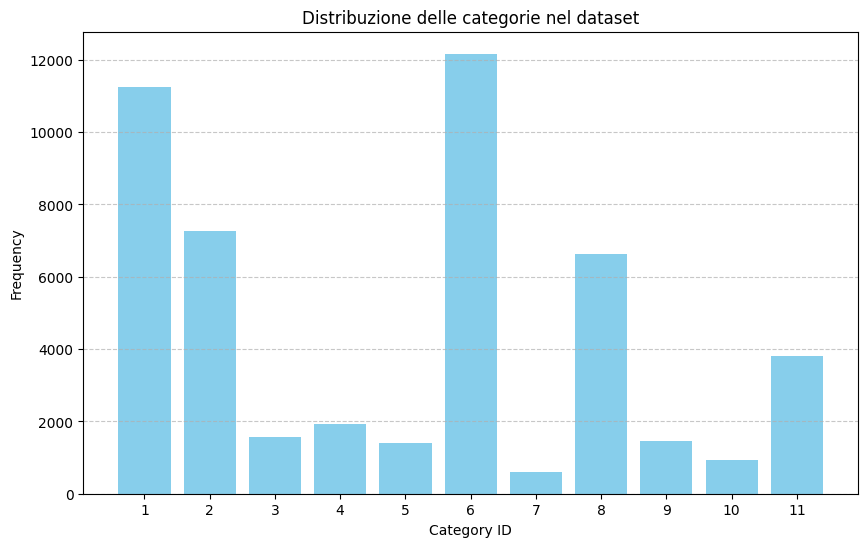

In [130]:
plot_category_distribution(new_coco_json_pth)

In [131]:
print("FINAL JSON")
display_images_with_bboxes(new_coco_json_pth, random_filename(new_coco_json_pth), img_fldr)

FINAL JSON


# Splitting

In [132]:
def split(json_file, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Carica il JSON
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Filtra le annotazioni con bounding box non validi
    valid_annotations = data['annotations']
    
    # Ottieni la lista delle immagini
    images = data['images']
    
    # Mescola casualmente gli ID delle immagini
    random.shuffle(images)
    
    # Calcola i limiti per train, validation e test
    total_images = len(images)
    total_annotations = len(valid_annotations)
    train_end = int(total_images * train_ratio)
    val_end = int(total_images * (train_ratio + val_ratio))
    
    # Suddividi le immagini nei rispettivi set
    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]
    
    # Raggruppa gli ID delle immagini per i rispettivi set
    train_image_ids = {image['id'] for image in train_images}
    val_image_ids = {image['id'] for image in val_images}
    test_image_ids = {image['id'] for image in test_images}
    
    # Filtra le annotazioni per i rispettivi set di immagini
    train_annotations = [ann for ann in valid_annotations if ann['image_id'] in train_image_ids]
    val_annotations = [ann for ann in valid_annotations if ann['image_id'] in val_image_ids]
    test_annotations = [ann for ann in valid_annotations if ann['image_id'] in test_image_ids]
    
    # Crea i nuovi JSON per train, validation e test
    train_data = {'images': train_images, 'annotations': train_annotations, 'categories': data['categories']}
    val_data = {'images': val_images, 'annotations': val_annotations, 'categories': data['categories']}
    test_data = {'images': test_images, 'annotations': test_annotations, 'categories': data['categories']}
    
    # Salva i file JSON
    with open('train.json', 'w') as f:
        json.dump(train_data, f, indent=4)
    
    with open('val.json', 'w') as f:
        json.dump(val_data, f, indent=4)
    
    with open('test.json', 'w') as f:
        json.dump(test_data, f, indent=4)
    
    # Controlla la proporzione delle immagini e delle annotazioni
    check_split_proportions(total_images, total_annotations, 
                            len(train_images), len(val_images), len(test_images), 
                            len(train_annotations), len(val_annotations), len(test_annotations), 
                            train_ratio, val_ratio, test_ratio, 
                            train_annotations, val_annotations, test_annotations, data['categories'])


def check_split_proportions(total_images, total_annotations, train_count, val_count, test_count, 
                            train_bbox_count, val_bbox_count, test_bbox_count, 
                            train_ratio, val_ratio, test_ratio, 
                            train_annotations, val_annotations, test_annotations, categories):
    # Percentuali per immagini
    train_image_percentage = (train_count / total_images) * 100
    val_image_percentage = (val_count / total_images) * 100
    test_image_percentage = (test_count / total_images) * 100
    
    # Percentuali per bbox
    train_bbox_percentage = (train_bbox_count / total_annotations) * 100
    val_bbox_percentage = (val_bbox_count / total_annotations) * 100
    test_bbox_percentage = (test_bbox_count / total_annotations) * 100
    
    print(f"Totale immagini: {total_images}")
    print(f"Totale annotazioni (bbox): {total_annotations}")
    print(f"Train: {train_count} immagini ({train_image_percentage:.2f}%) ({train_bbox_count} bbox) ({train_bbox_percentage:.2f}%)")
    print(f"Val: {val_count} immagini ({val_image_percentage:.2f}%) ({val_bbox_count} bbox) ({val_bbox_percentage:.2f}%)")
    print(f"Test: {test_count} immagini ({test_image_percentage:.2f}%) ({test_bbox_count} bbox) ({test_bbox_percentage:.2f}%)")
    
    # Calcola il numero di annotazioni per categoria nei vari set
    category_count_train = defaultdict(int)
    category_count_val = defaultdict(int)
    category_count_test = defaultdict(int)
    
    for annotation in train_annotations:
        category_count_train[annotation['category_id']] += 1
    for annotation in val_annotations:
        category_count_val[annotation['category_id']] += 1
    for annotation in test_annotations:
        category_count_test[annotation['category_id']] += 1
    
    # Stampa le proporzioni per categoria
    print("\nProporzioni per categoria:")
    for category in categories:
        try:
            category_id = int(category['id'])  # Converte 'id' in un intero
            category_name = category['name']
    
            # Conta il numero di annotazioni per categoria in ogni set
            train_cat_count = category_count_train.get(category_id, 0)
            val_cat_count = category_count_val.get(category_id, 0)
            test_cat_count = category_count_test.get(category_id, 0)
    
            # Calcola la percentuale di annotazioni per categoria
            total_cat_annotations = train_cat_count + val_cat_count + test_cat_count
            if total_cat_annotations > 0:
                train_cat_percentage = (train_cat_count / total_cat_annotations) * 100
                val_cat_percentage = (val_cat_count / total_cat_annotations) * 100
                test_cat_percentage = (test_cat_count / total_cat_annotations) * 100
            else:
                train_cat_percentage = val_cat_percentage = test_cat_percentage = 0.0
    
            print(f"{category_name}:")
            print(f"  Train: {train_cat_count} annotazioni ({train_cat_percentage:.2f}%)")
            print(f"  Val: {val_cat_count} annotazioni ({val_cat_percentage:.2f}%)")
            print(f"  Test: {test_cat_count} annotazioni ({test_cat_percentage:.2f}%)")
        except KeyError as e:
            print(f"Chiave mancante nella categoria: {e}")
        except ValueError as e:
            print(f"Errore nel parsing della categoria: {e}")


In [133]:
# Chiamata della funzione
split(new_coco_json_pth)

Totale immagini: 6101
Totale annotazioni (bbox): 48993
Train: 4880 immagini (79.99%) (38646 bbox) (78.88%)
Val: 610 immagini (10.00%) (4893 bbox) (9.99%)
Test: 611 immagini (10.01%) (5454 bbox) (11.13%)

Proporzioni per categoria:
Aircraft:
  Train: 2975 annotazioni (78.04%)
  Val: 452 annotazioni (11.86%)
  Test: 385 annotazioni (10.10%)
Passenger Vehicle:
  Train: 8896 annotazioni (79.15%)
  Val: 860 annotazioni (7.65%)
  Test: 1483 annotazioni (13.20%)
Truck:
  Train: 5619 annotazioni (77.30%)
  Val: 886 annotazioni (12.19%)
  Test: 764 annotazioni (10.51%)
Railway Vehicle:
  Train: 1401 annotazioni (89.07%)
  Val: 59 annotazioni (3.75%)
  Test: 113 annotazioni (7.18%)
Maritime Vessel:
  Train: 1417 annotazioni (73.65%)
  Val: 310 annotazioni (16.11%)
  Test: 197 annotazioni (10.24%)
Engineering Vehicle:
  Train: 1104 annotazioni (79.14%)
  Val: 145 annotazioni (10.39%)
  Test: 146 annotazioni (10.47%)
Building:
  Train: 9682 annotazioni (79.58%)
  Val: 1081 annotazioni (8.88%)
  Te

TRAIN
VALIDATION
TEST


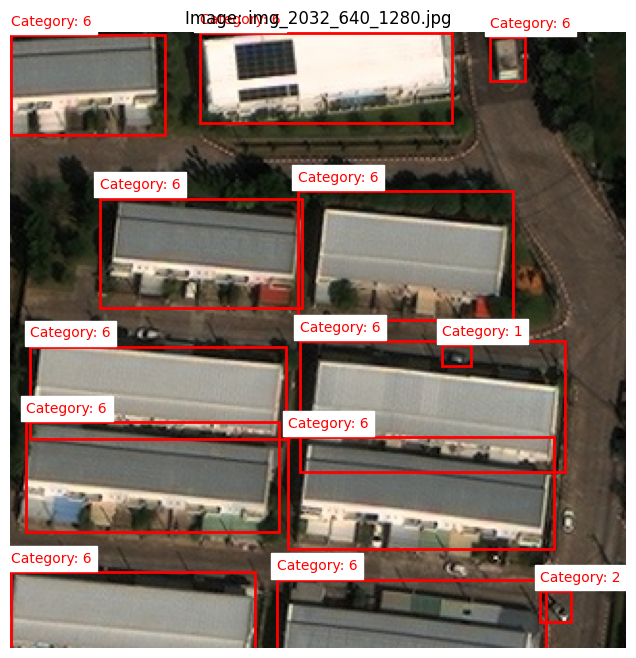

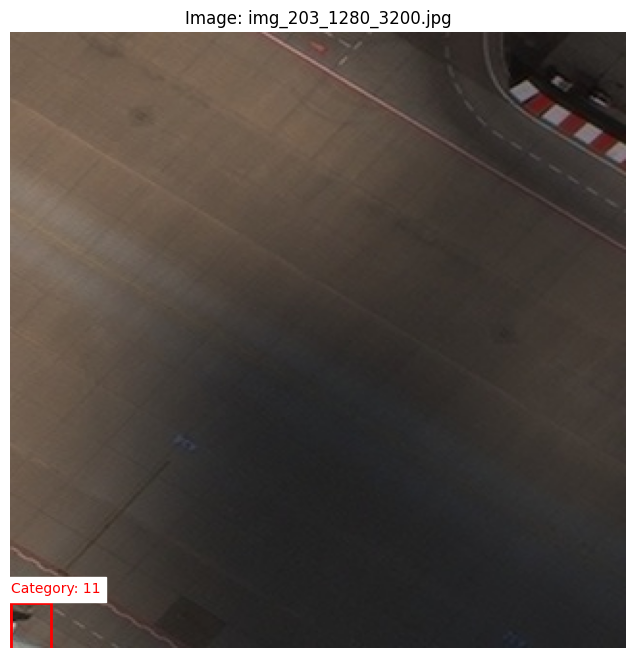

In [134]:
print("TRAIN")
train_filenames = random_filename(train_path)
display_images_with_bboxes(train_path, train_filenames, img_fldr)
print("VALIDATION")
val_filenames = random_filename(val_path)
display_images_with_bboxes(val_path, val_filenames, img_fldr)
print("TEST")
test_filenames = random_filename(test_path)
display_images_with_bboxes(test_path, test_filenames, img_fldr)

# Dataloader

In [135]:
class CustomDataset(Dataset):
    def __init__(self, json_file, img_dir, aug=False):
        """
        Inizializza il dataset personalizzato.
        Args:
        - json_file: Il file JSON preprocessato contenente immagini, annotazioni e categorie.
        - img_dir: La directory contenente le immagini.
        - aug: Booleano per attivare o meno l'augmentazione.
        """
        # Carica il file JSON preprocessato
        with open(json_file, 'r') as f:
            coco_data = json.load(f)

        # Estrai informazioni su immagini, annotazioni e categorie
        self.image_info = {image['id']: image['file_name'] for image in coco_data['images']}
        self.image_annotations = {}
        self.image_bboxes = {}

        # Estrai le classi (categorie) dal file JSON
        self.classes = {}
        for category in coco_data['categories']:
            category_id = category['id']  # ID numerico
            category_name = category['name']  # Nome della categoria
            self.classes[int(category_id)] = category_name


        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            bbox = annotation['bbox']

            # Associa annotazioni e bounding box alle immagini
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
                self.image_bboxes[image_id] = []
            
            self.image_annotations[image_id].append(annotation['category_id'])
            self.image_bboxes[image_id].append(bbox)

        # Configura il percorso delle immagini e seleziona solo immagini valide
        self.img_dir = img_dir
        self.image_paths = []
        self.image_ids = []
        for image_id, file_name in self.image_info.items():
            if image_id in self.image_annotations:
                img_path = os.path.join(img_dir, file_name)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.image_ids.append(image_id)

        # Definisci trasformazioni
        self.base_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        self.aug_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        self.aug = aug

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Recupera un'immagine e le sue annotazioni.
        """
        img_path = self.image_paths[index]
        img_id = self.image_ids[index]

        # Carica l'immagine
        image = Image.open(img_path).convert('RGB')
        original_width, original_height = image.size

        # Applica le trasformazioni
        if self.aug:
            image_tensor = self.aug_transform(image)
        else:
            image_tensor = self.base_transform(image)

        # Recupera le annotazioni e i bounding box
        categories = self.image_annotations[img_id]
        bboxes = self.image_bboxes[img_id]

        # Calcola il ridimensionamento
        scale_x = 224 / original_width
        scale_y = 224 / original_height

        # Ridimensiona i bounding box
        scaled_bboxes = [
            torch.tensor([
                bbox[0] * scale_x,  # x_min
                bbox[1] * scale_y,  # y_min
                bbox[2] * scale_x,  # x_max
                bbox[3] * scale_y   # y_max
            ], dtype=torch.float32)
            for bbox in bboxes
        ]

        # Costruisci il target
        target = {
            "boxes": torch.stack(scaled_bboxes),
            "labels": torch.tensor(categories, dtype=torch.int64)
        }

        return image_tensor, target

In [136]:
def collate_fn(batch):
    """
    Funzione di collation per il DataLoader, utile per il batching di immagini e annotazioni.
    La funzione restituirà un batch di immagini e un batch di target, formattato correttamente per Faster R-CNN.
    
    Args:
    - batch: lista di tuple (image, target)
    
    Returns:
    - images: batch di immagini
    - targets: lista di dizionari contenenti le annotazioni per ogni immagine
    """
    # Separa immagini e target
    images, targets = zip(*batch)

    # Converte la lista di immagini in un batch di immagini
    images = list(images)

    # Restituisci il batch
    return images, list(targets)

In [137]:
# Creazione dei dataset
train_dataset = CustomDataset(train_path, img_dir=img_fldr, aug=True)
valid_dataset = CustomDataset(val_path, img_dir=img_fldr, aug=False)  
test_dataset = CustomDataset(test_path, img_dir=img_fldr, aug=False)  

# Creazione dei DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

## Check Dataloader

In [138]:
def validate_dataloader(dataloader):
    """
    Valida un DataLoader verificando che ogni immagine abbia un target associato
    e che nessun target sia `None` o vuoto.
    
    Args:
    - dataloader: Il DataLoader da verificare.
    
    Returns:
    - error_messages: Lista di messaggi di errore. Vuota se tutti i dati sono validi.
    """
    error_messages = []
    for batch_idx, (images, targets) in enumerate(dataloader):
        for idx, target in enumerate(targets):
            if target is None:
                error_messages.append(f"Batch {batch_idx}, Immagine {idx}: Target è None.")
            elif target["boxes"].numel() == 0 or target["labels"].numel() == 0:
                error_messages.append(
                    f"Batch {batch_idx}, Immagine {idx}: Target è vuoto o mancano 'boxes'/'labels'."
                )
    return error_messages

In [139]:
# Validazione del DataLoader di training
train_errors = validate_dataloader(train_loader)

if train_errors:
    print("Errori nel DataLoader di training:")
    for error in train_errors:
        print(error)
else:
    print("Tutti i target nel DataLoader di training sono validi.")

Tutti i target nel DataLoader di training sono validi.


In [140]:
# Validazione del DataLoader di validation
val_errors = validate_dataloader(val_loader)

if val_errors:
    print("Errori nel DataLoader di validation:")
    for error in val_errors:
        print(error)
else:
    print("Tutti i target nel DataLoader di validation sono validi.")

Tutti i target nel DataLoader di validation sono validi.


In [141]:
# Validazione del DataLoader di test
test_errors = validate_dataloader(test_loader)

if test_errors:
    print("Errori nel DataLoader di test:")
    for error in test_errors:
        print(error)
else:
    print("Tutti i target nel DataLoader di test sono validi.")

Tutti i target nel DataLoader di test sono validi.


In [142]:
def count_images_and_targets(dataloader):
    """
    Conta il numero totale di immagini e target in un DataLoader.
    """
    num_images = 0
    num_targets = 0

    for images, targets in dataloader:
        # Conta le immagini nel batch
        num_images += len(images)
        
        # Conta i target per ogni immagine (numero di oggetti)
        for target in targets:
            num_targets += len(target["boxes"])  # Ogni immagine ha un numero di bounding boxes
    
    return num_images, num_targets

In [143]:
num_images_train, num_targets_train = count_images_and_targets(train_loader)

print(f"Numero totale di immagini per il train: {num_images_train}")
print(f"Numero totale di target per il train: {num_targets_train}")

Numero totale di immagini per il train: 3709
Numero totale di target per il train: 38646


In [144]:
num_images_val, num_targets_val = count_images_and_targets(val_loader)

print(f"Numero totale di immagini per il validation: {num_images_val}")
print(f"Numero totale di target per il validation: {num_targets_val}")

Numero totale di immagini per il validation: 478
Numero totale di target per il validation: 4893


In [145]:
num_images_test, num_targets_test = count_images_and_targets(test_loader)

print(f"Numero totale di immagini per il test: {num_images_test}")
print(f"Numero totale di target per il test: {num_targets_test}")

Numero totale di immagini per il test: 443
Numero totale di target per il test: 5454


In [146]:
print(f"Numero totale di immagini: {num_images_train + num_images_val +num_images_test}")
print(f"Numero totale di target: {num_targets_train + num_targets_val +num_targets_test}")

Numero totale di immagini: 4630
Numero totale di target: 48993


TRAIN


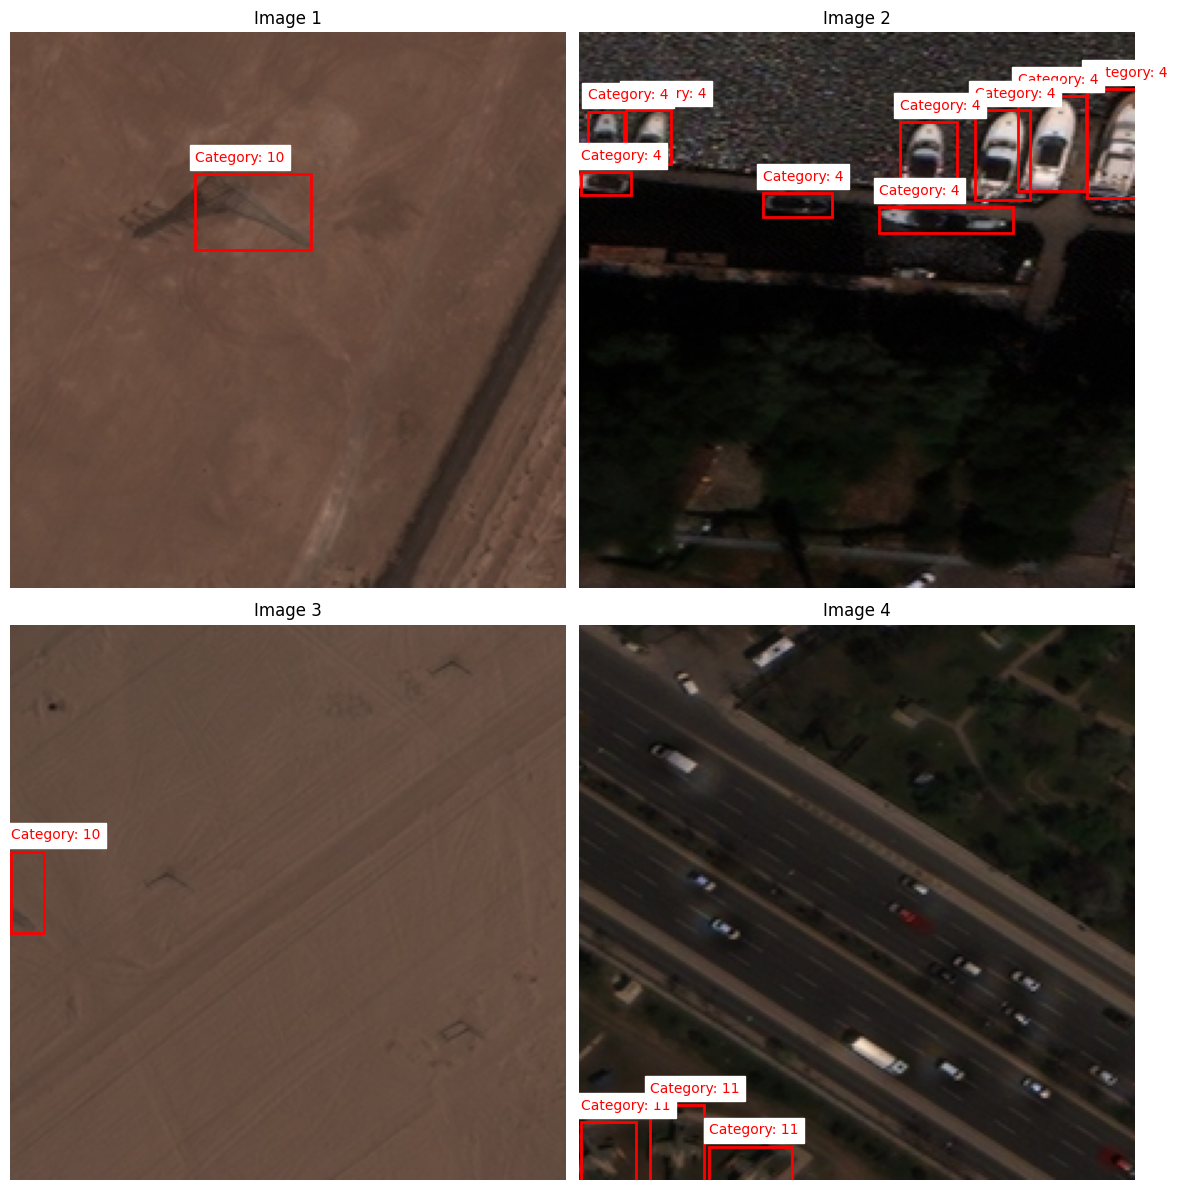

VALIDATION


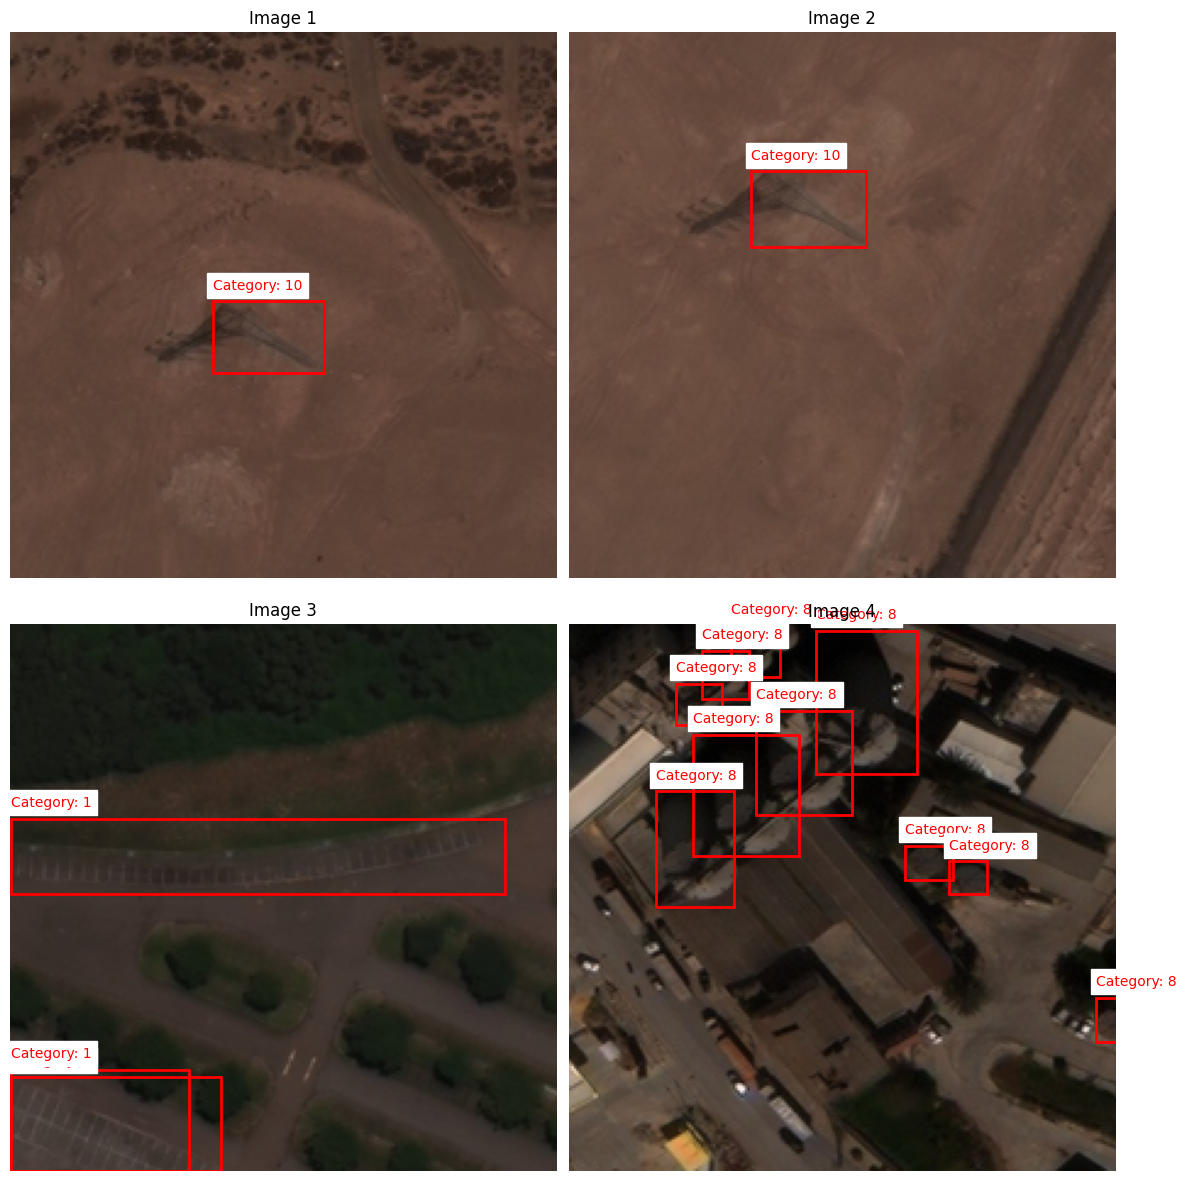

TEST


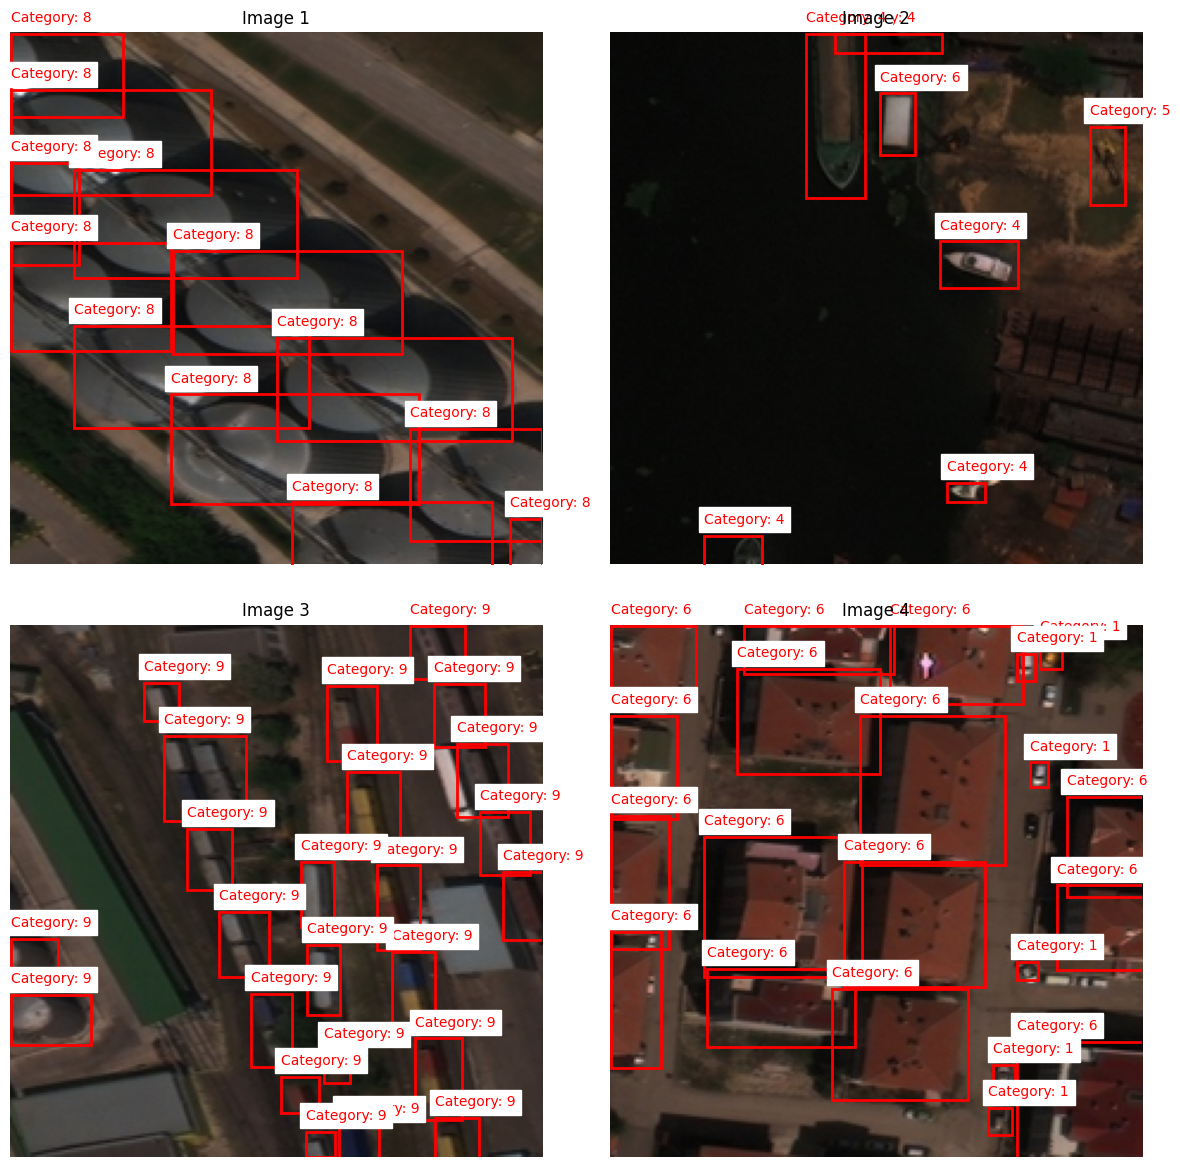

In [147]:
print("TRAIN")
display_images_with_bboxes_dataloader(train_loader)
print("VALIDATION")
display_images_with_bboxes_dataloader(val_loader)
print("TEST")
display_images_with_bboxes_dataloader(test_loader)

# Training

In [148]:
def train_and_validate(model, train_loader, val_loader, optimizer, device, num_epochs=10, num_classes=12, accumulation_steps=4):
    """
    Addestra e valida il modello Faster R-CNN.
    """
    # Scaler per mixed precision training
    scaler = GradScaler()

    # Sposta il modello sul dispositivo
    model.to(device)

    train_losses = []
    val_losses = []
    train_confidences = []
    val_confidences = []
    train_precisions = []
    train_recalls = []
    val_precisions = []
    val_recalls = []

    for epoch in range(num_epochs):
        print(f"\nEpoca {epoch + 1}/{num_epochs}")

        # --------------------
        # Training
        # --------------------
        model.train()
        total_train_loss = 0.0
        train_loop = tqdm(train_loader, desc="Training", leave=False)

        for i, (images, targets) in enumerate(train_loop):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with autocast('cuda'):
                # Calcola le perdite
                loss_dict = model(images, targets)

                # Controlla che il risultato sia un dizionario
                if not isinstance(loss_dict, dict):
                    raise ValueError(f"Il modello ha restituito un oggetto non valido: {type(loss_dict)}")
                
                # Somma delle perdite
                losses = sum(loss for loss in loss_dict.values())

            # Backward pass con gradient scaling
            scaler.scale(losses).backward()

            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_train_loss += losses.item()
            train_loop.set_postfix(loss=losses.item())

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Perdita media di training: {avg_train_loss:.4f}")

        # Calcolo metriche per il training
        train_precision, train_recall, train_conf = evaluate_metrics(model, train_loader, device, num_classes)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_confidences.append(train_conf)
        print(f"Precision di training: {train_precision:.4f}, Recall di training: {train_recall:.4f}, Confidenza media di training: {train_conf:.4f}")

        # --------------------
        # Validazione
        # --------------------
        model.train()  # Necessario per calcolare la loss
        total_val_loss = 0.0
        val_loop = tqdm(val_loader, desc="Validazione", leave=False)

        for i, (images, targets) in enumerate(val_loop):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Calcolo delle perdite nella validazione
            with torch.no_grad(), autocast('cuda'):
                loss_dict = model(images, targets)
                if not isinstance(loss_dict, dict):
                    raise ValueError(f"Il modello ha restituito un oggetto non valido: {type(loss_dict)}")
                losses = sum(loss for loss in loss_dict.values())
                total_val_loss += losses.item()
                val_loop.set_postfix(loss=losses.item())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Perdita media di validazione: {avg_val_loss:.4f}")

        # Calcolo metriche per la validazione
        val_precision, val_recall, val_conf = evaluate_metrics(model, val_loader, device, num_classes)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_confidences.append(val_conf)
        print(f"Precision di validazione: {val_precision:.4f}, Recall di validazione: {val_recall:.4f}, Confidenza media di validazione: {val_conf:.4f}")

        # --------------------
        # Salvataggio del modello
        # --------------------
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
        print(f"Modello salvato: model_epoch_{epoch + 1}.pth")

    return train_losses, val_losses, train_precisions, train_recalls, train_confidences, val_precisions, val_recalls, val_confidences

In [149]:
def evaluate_metrics(model, data_loader, device, num_classes, iou_threshold=0.5, score_threshold=0.2):
    """
    Calcola Precision, Recall e la confidenza media basati su IoU per Faster R-CNN.
    Aggiunto il controllo delle predizioni e dei dati.
    """
    model.eval()
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes
    total_confidence = 0.0
    num_valid_predictions = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Predizioni
            outputs = model(images)

            for target, output in zip(targets, outputs):
                target_boxes = target['boxes'].cpu()
                target_labels = target['labels'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_labels = output['labels'].cpu()
                pred_scores = output['scores'].cpu()

                # Filtra predizioni con punteggio basso
                high_score_indices = pred_scores > score_threshold
                pred_boxes = pred_boxes[high_score_indices]
                pred_labels = pred_labels[high_score_indices]
                pred_scores = pred_scores[high_score_indices]

                if len(pred_boxes) > 0 and len(target_boxes) > 0:
                    ious = box_iou(pred_boxes, target_boxes)  # IoU
                    for pred_idx, pred_label in enumerate(pred_labels):
                        iou_values = ious[pred_idx]
                        max_iou_idx = torch.argmax(iou_values)
                        max_iou = iou_values[max_iou_idx]

                        if max_iou >= iou_threshold and pred_label == target_labels[max_iou_idx]:
                            true_positives[pred_label] += 1
                            total_confidence += pred_scores[pred_idx].item()
                            num_valid_predictions += 1
                            ious[:, max_iou_idx] = 0  # Disabilita target già usati
                        else:
                            false_positives[pred_label] += 1

                # False negatives
                for target_label in target_labels:
                    if target_label not in pred_labels:
                        false_negatives[target_label] += 1

    # Precision e Recall globali
    precision = sum(true_positives) / (sum(true_positives) + sum(false_positives) + 1e-6)
    recall = sum(true_positives) / (sum(true_positives) + sum(false_negatives) + 1e-6)

    # Confidenza media
    average_confidence = total_confidence / num_valid_predictions if num_valid_predictions > 0 else 0.0

    return precision, recall, average_confidence

In [150]:
def plot_metrics(train_losses, val_losses, train_precisions, train_recalls, train_confidences, 
                 val_precisions, val_recalls, val_confidences, num_epochs): 
    """ Funzione per plottare le metriche di training e validazione (Loss, Precision, Recall, Confidence). """ 
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 12))

    # Plot della Loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss per Epoca')

    # Plot della Precision
    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, train_precisions, label='Training Precision', color='green')
    plt.plot(epochs_range, val_precisions, label='Validation Precision', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision per Epoca')

    # Plot del Recall
    plt.subplot(3, 2, 3)
    plt.plot(epochs_range, train_recalls, label='Training Recall', color='purple')
    plt.plot(epochs_range, val_recalls, label='Validation Recall', color='pink')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall per Epoca')

    # Plot della Confidence
    plt.subplot(3, 2, 4)
    plt.plot(epochs_range, train_confidences, label='Training Confidence', color='cyan')
    plt.plot(epochs_range, val_confidences, label='Validation Confidence', color='magenta')
    plt.xlabel('Epochs')
    plt.ylabel('Confidence')
    plt.legend()
    plt.title('Confidence per Epoca')

    # Aggiungi il layout stretto per evitare sovrapposizioni
    plt.tight_layout()
    plt.show()

In [151]:
# Carica il modello Faster R-CNN con ResNet50 e FPN
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 167MB/s]  


In [152]:
num_classes = 12

# Modifica il numero di classi in output
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Congela i layer della backbone (ResNet50)
for param in model.backbone.parameters():
    param.requires_grad = True

# Imposta il dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configurazione training
num_epochs = 10
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Sposta il modello su GPU o CPU
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [153]:
train_losses, val_losses, train_precisions, train_recalls, train_confidences, val_precisions, val_recalls, val_confidences = train_and_validate(model, train_loader, val_loader, optimizer, device, num_epochs)


Epoca 1/10


Perdita media di training: 0.8361


True Positives: [0, 5856, 3693, 1034, 0, 706, 7000, 487, 5212, 464, 745, 2905]
False Positives: [0, 19032, 5206, 570, 0, 1470, 31442, 164, 1555, 31, 497, 949]
False Negatives: [0, 48, 166, 243, 1417, 135, 14, 36, 13, 260, 12, 17]
Precision: 0.3157, Recall: 0.9225, Average Confidence: 0.7301
Precision di training: 0.3157, Recall di training: 0.9225, Confidenza media di training: 0.7301


Perdita media di validazione: 0.5478


True Positives: [0, 578, 572, 46, 0, 76, 746, 39, 723, 176, 105, 441]
False Positives: [0, 2382, 932, 32, 0, 63, 3746, 39, 231, 12, 56, 118]
False Negatives: [0, 5, 17, 11, 310, 33, 7, 1, 1, 17, 1, 2]
Precision: 0.3151, Recall: 0.8963, Average Confidence: 0.7311
Precision di validazione: 0.3151, Recall di validazione: 0.8963, Confidenza media di validazione: 0.7311
Modello salvato: model_epoch_1.pth

Epoca 2/10


Perdita media di training: 0.5103


True Positives: [0, 6094, 4585, 1257, 704, 958, 7155, 519, 5235, 747, 745, 2955]
False Positives: [0, 13062, 3162, 786, 195, 2760, 19029, 185, 1804, 612, 344, 269]
False Negatives: [0, 79, 161, 8, 98, 44, 54, 4, 6, 53, 12, 7]
Precision: 0.4231, Recall: 0.9833, Average Confidence: 0.7846
Precision di training: 0.4231, Recall di training: 0.9833, Confidenza media di training: 0.7846


Perdita media di validazione: 0.4708


True Positives: [0, 591, 693, 50, 143, 106, 729, 40, 729, 195, 105, 447]
False Positives: [0, 1728, 442, 99, 33, 278, 2059, 38, 228, 152, 51, 24]
False Negatives: [0, 11, 22, 2, 25, 11, 9, 0, 0, 7, 1, 1]
Precision: 0.4272, Recall: 0.9773, Average Confidence: 0.7863
Precision di validazione: 0.4272, Recall di validazione: 0.9773, Confidenza media di validazione: 0.7863
Modello salvato: model_epoch_2.pth

Epoca 3/10


Perdita media di training: 0.4334


True Positives: [0, 6119, 4831, 1321, 1071, 1010, 6774, 519, 5242, 803, 757, 2968]
False Positives: [0, 7837, 1882, 896, 245, 1177, 10249, 107, 979, 417, 154, 494]
False Negatives: [0, 65, 116, 12, 33, 41, 51, 4, 6, 45, 0, 7]
Precision: 0.5625, Recall: 0.9880, Average Confidence: 0.7934
Precision di training: 0.5625, Recall di training: 0.9880, Confidenza media di training: 0.7934


Perdita media di validazione: 0.4480


True Positives: [0, 548, 718, 56, 201, 108, 639, 40, 731, 194, 106, 451]
False Positives: [0, 1065, 250, 113, 36, 120, 1218, 33, 98, 111, 26, 55]
False Negatives: [0, 14, 20, 2, 5, 15, 15, 0, 0, 8, 0, 1]
Precision: 0.5482, Recall: 0.9793, Average Confidence: 0.8104
Precision di validazione: 0.5482, Recall di validazione: 0.9793, Confidenza media di validazione: 0.8104
Modello salvato: model_epoch_3.pth

Epoca 4/10


Perdita media di training: 0.3772


True Positives: [0, 6952, 4779, 1330, 1096, 1030, 8108, 519, 5253, 877, 757, 2975]
False Positives: [0, 16657, 860, 357, 947, 780, 17413, 107, 534, 836, 12, 303]
False Negatives: [0, 27, 248, 5, 12, 39, 26, 4, 0, 17, 0, 0]
Precision: 0.4646, Recall: 0.9889, Average Confidence: 0.8335
Precision di training: 0.4646, Recall di training: 0.9889, Confidenza media di training: 0.8335


Perdita media di validazione: 0.4256


True Positives: [0, 649, 690, 53, 199, 103, 766, 40, 731, 201, 106, 452]
False Positives: [0, 2211, 156, 32, 128, 90, 2076, 31, 56, 180, 5, 27]
False Negatives: [0, 9, 41, 2, 2, 11, 13, 0, 0, 7, 0, 0]
Precision: 0.4442, Recall: 0.9791, Average Confidence: 0.8350
Precision di validazione: 0.4442, Recall di validazione: 0.9791, Confidenza media di validazione: 0.8350
Modello salvato: model_epoch_4.pth

Epoca 5/10


Perdita media di training: 0.3355


True Positives: [0, 6781, 5015, 1365, 1154, 1048, 8327, 519, 5253, 868, 757, 2973]
False Positives: [0, 7522, 874, 391, 64, 329, 13828, 100, 171, 240, 31, 184]
False Negatives: [0, 68, 176, 2, 26, 37, 34, 4, 4, 39, 0, 2]
Precision: 0.5893, Recall: 0.9886, Average Confidence: 0.8574
Precision di training: 0.5893, Recall di training: 0.9886, Confidenza media di training: 0.8574


Perdita media di validazione: 0.4320


True Positives: [0, 579, 712, 52, 209, 98, 721, 40, 732, 194, 106, 452]
False Positives: [0, 1041, 161, 32, 11, 31, 1750, 31, 24, 54, 5, 13]
False Negatives: [0, 15, 37, 2, 17, 39, 16, 0, 0, 10, 0, 0]
Precision: 0.5526, Recall: 0.9663, Average Confidence: 0.8623
Precision di validazione: 0.5526, Recall di validazione: 0.9663, Confidenza media di validazione: 0.8623
Modello salvato: model_epoch_5.pth

Epoca 6/10


Perdita media di training: 0.2987


True Positives: [0, 7122, 5353, 1375, 1212, 1071, 8415, 519, 5257, 931, 757, 2972]
False Positives: [0, 10417, 4103, 435, 304, 477, 8696, 107, 371, 267, 7, 291]
False Negatives: [0, 49, 27, 2, 5, 21, 25, 4, 0, 8, 0, 3]
Precision: 0.5786, Recall: 0.9959, Average Confidence: 0.8911
Precision di training: 0.5786, Recall di training: 0.9959, Confidenza media di training: 0.8911


Perdita media di validazione: 0.4283


True Positives: [0, 595, 776, 57, 216, 100, 642, 40, 732, 197, 106, 452]
False Positives: [0, 1384, 681, 51, 58, 45, 1281, 32, 41, 74, 4, 28]
False Negatives: [0, 7, 7, 2, 2, 36, 22, 0, 0, 2, 0, 0]
Precision: 0.5154, Recall: 0.9805, Average Confidence: 0.8813
Precision di validazione: 0.5154, Recall di validazione: 0.9805, Confidenza media di validazione: 0.8813
Modello salvato: model_epoch_6.pth

Epoca 7/10


Perdita media di training: 0.2645


True Positives: [0, 7146, 5330, 1386, 1240, 1078, 8578, 522, 5257, 962, 757, 2975]
False Positives: [0, 5732, 997, 464, 286, 451, 5296, 79, 202, 359, 25, 164]
False Negatives: [0, 29, 62, 1, 4, 14, 46, 1, 0, 5, 0, 0]
Precision: 0.7148, Recall: 0.9954, Average Confidence: 0.9019
Precision di training: 0.7148, Recall di training: 0.9954, Confidenza media di training: 0.9019


Perdita media di validazione: 0.4762


True Positives: [0, 527, 736, 57, 227, 105, 614, 40, 732, 199, 106, 452]
False Positives: [0, 899, 239, 59, 85, 56, 892, 24, 20, 110, 4, 13]
False Negatives: [0, 16, 25, 2, 2, 18, 39, 0, 0, 8, 0, 0]
Precision: 0.6125, Recall: 0.9718, Average Confidence: 0.8924
Precision di validazione: 0.6125, Recall di validazione: 0.9718, Confidenza media di validazione: 0.8924
Modello salvato: model_epoch_7.pth

Epoca 8/10


Perdita media di training: 0.2453


True Positives: [0, 7178, 5394, 1383, 1226, 1085, 8887, 523, 5257, 979, 757, 2972]
False Positives: [0, 4825, 935, 104, 138, 390, 6051, 99, 96, 403, 38, 157]
False Negatives: [0, 49, 59, 1, 2, 14, 41, 0, 0, 4, 0, 3]
Precision: 0.7292, Recall: 0.9952, Average Confidence: 0.9116
Precision di training: 0.7292, Recall di training: 0.9952, Confidenza media di training: 0.9116


Perdita media di validazione: 0.4699


True Positives: [0, 504, 737, 52, 216, 103, 643, 40, 732, 200, 106, 452]
False Positives: [0, 795, 256, 8, 36, 51, 1065, 30, 12, 92, 5, 11]
False Negatives: [0, 14, 20, 2, 4, 20, 28, 0, 0, 8, 0, 0]
Precision: 0.6158, Recall: 0.9753, Average Confidence: 0.8964
Precision di validazione: 0.6158, Recall di validazione: 0.9753, Confidenza media di validazione: 0.8964
Modello salvato: model_epoch_8.pth

Epoca 9/10


Perdita media di training: 0.2207


True Positives: [0, 7376, 5398, 1386, 1245, 1087, 9008, 523, 5257, 978, 757, 2975]
False Positives: [0, 4682, 617, 146, 172, 260, 4773, 104, 120, 153, 2, 155]
False Negatives: [0, 58, 56, 2, 2, 15, 50, 0, 0, 5, 0, 0]
Precision: 0.7629, Recall: 0.9948, Average Confidence: 0.9300
Precision di training: 0.7629, Recall di training: 0.9948, Confidenza media di training: 0.9300


Perdita media di validazione: 0.5076


True Positives: [0, 510, 725, 55, 217, 100, 616, 40, 732, 194, 106, 452]
False Positives: [0, 867, 186, 8, 41, 21, 903, 31, 13, 50, 2, 11]
False Negatives: [0, 23, 43, 2, 4, 38, 28, 0, 0, 10, 0, 0]
Precision: 0.6372, Recall: 0.9620, Average Confidence: 0.9096
Precision di validazione: 0.6372, Recall di validazione: 0.9620, Confidenza media di validazione: 0.9096
Modello salvato: model_epoch_9.pth

Epoca 10/10


Perdita media di training: 0.2050


True Positives: [0, 7475, 5471, 1398, 1245, 1088, 9150, 523, 5257, 980, 757, 2975]
False Positives: [0, 4851, 1029, 364, 331, 238, 6053, 96, 315, 200, 7, 203]
False Negatives: [0, 22, 42, 1, 0, 12, 35, 0, 0, 5, 0, 0]
Precision: 0.7263, Recall: 0.9968, Average Confidence: 0.9421
Precision di training: 0.7263, Recall di training: 0.9968, Confidenza media di training: 0.9421


Perdita media di validazione: 0.4810


True Positives: [0, 515, 746, 56, 222, 101, 667, 40, 732, 196, 106, 452]
False Positives: [0, 895, 319, 62, 71, 41, 1150, 29, 40, 83, 2, 19]
False Negatives: [0, 18, 16, 2, 4, 26, 27, 0, 0, 10, 0, 0]
Precision: 0.5857, Recall: 0.9738, Average Confidence: 0.9089
Precision di validazione: 0.5857, Recall di validazione: 0.9738, Confidenza media di validazione: 0.9089
Modello salvato: model_epoch_10.pth


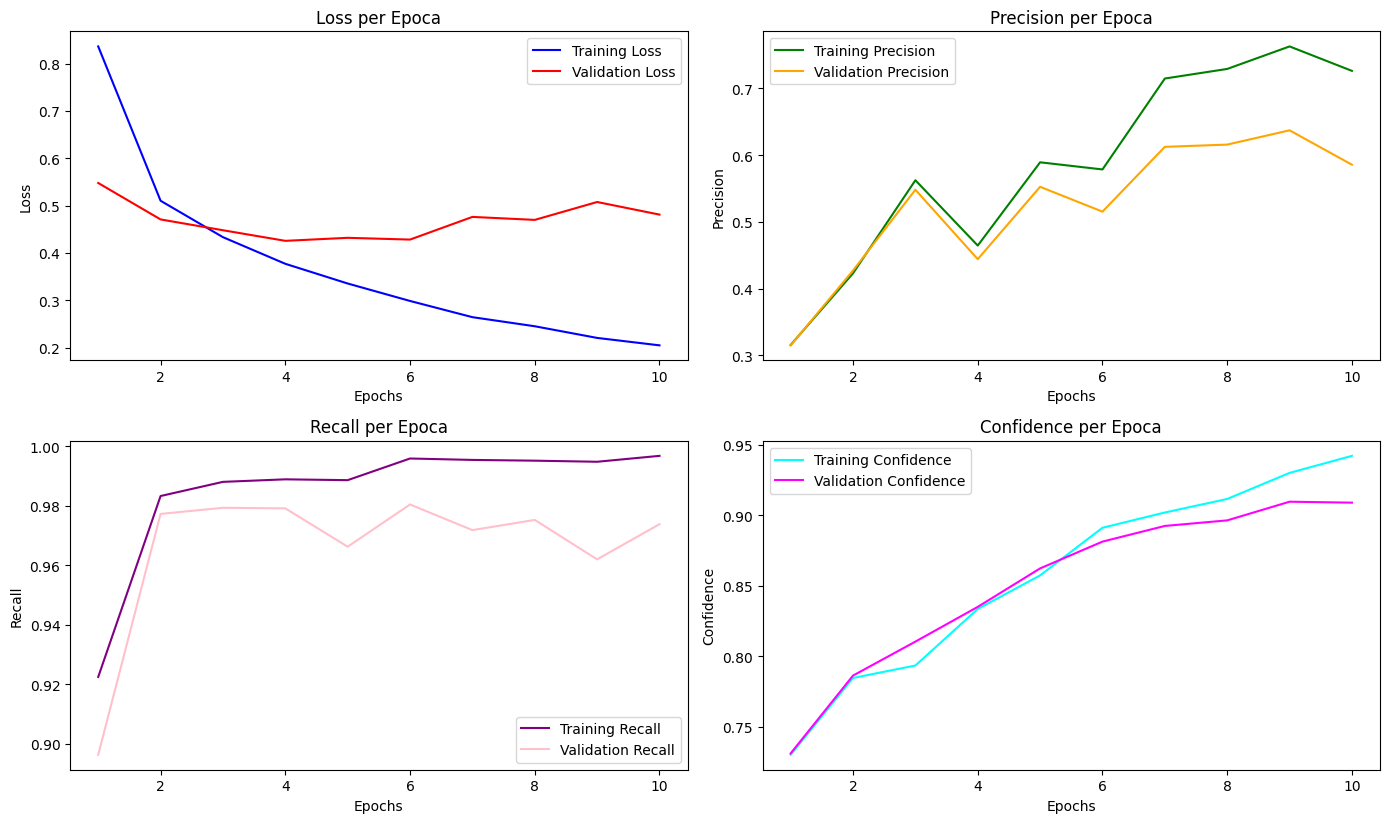

In [154]:
plot_metrics(train_losses, val_losses, train_precisions, train_recalls, train_confidences, val_precisions, val_recalls, val_confidences, num_epochs)

# Testing

In [155]:
def test_model(model, test_loader, device, class_names, num_classes=12, num_visualizations=5):
    """
    Funzione per il testing del modello Faster R-CNN.
    """
    model.to(device)
    model.eval()
    predictions = []
    all_preds = []  # Per calcolo mAP
    all_targets = []  # Per calcolo mAP

    print("\nInizio testing...")
    visualizations_done = 0  # Contatore per visualizzazioni
    visualized_indices = set()  # Per tenere traccia delle immagini già visualizzate

    with torch.no_grad():
        for idx, (images, targets) in enumerate(test_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Targets su dispositivo

            # Predizioni dal modello
            preds = model(images)

            # Mescola l'ordine delle immagini per la visualizzazione casuale
            data = list(zip(images, preds, targets))
            random.shuffle(data)

            for image, pred, target in data:
                predictions.append({
                    'boxes': pred['boxes'].cpu().numpy(),
                    'labels': pred['labels'].cpu().numpy(),
                    'scores': pred['scores'].cpu().numpy()
                })

                # Raccogli predizioni e target per calcolo mAP
                all_preds.append(pred)
                all_targets.append(target)

                # Visualizza immagini con bounding box casuali
                if visualizations_done < num_visualizations and id(image) not in visualized_indices:
                    visualize_predictions(
                        image.cpu().numpy().transpose(1, 2, 0),  # Converti (C, H, W) -> (H, W, C)
                        pred['boxes'].cpu().numpy(),
                        pred['labels'].cpu().numpy(),
                        pred['scores'].cpu().numpy(),
                        class_names
                    )
                    visualized_indices.add(id(image))
                    visualizations_done += 1

                if visualizations_done >= num_visualizations:
                    break  # Interrompi quando hai raggiunto il numero di visualizzazioni richieste

    # Visualizza la confusion matrix
    plot_confusion_matrix(all_preds, all_targets, class_names)

    print("Testing completato.")
    return predictions

In [185]:
def visualize_predictions(image, boxes, labels, scores, class_names, threshold=0.3):
    """
    Visualizza le predizioni (bounding boxes e etichette) su una singola immagine.

    Args:
        image (numpy.ndarray): Immagine in formato (H, W, C).
        boxes (numpy.ndarray): Array di bounding boxes (xmin, ymin, xmax, ymax).
        labels (numpy.ndarray): Array di etichette corrispondenti alle classi.
        scores (numpy.ndarray): Array di punteggi di confidenza.
        class_names (list): Lista dei nomi delle classi.
        threshold (float): Soglia di confidenza per visualizzare le predizioni.
    """
    # Crea una mappa di colori per le classi
    unique_labels = np.unique(labels)
    colors = {label: tuple(np.random.rand(3)) for label in unique_labels}

    fig, ax = plt.subplots(1, figsize=(image.shape[1] / 30, image.shape[0] / 30))
    ax.imshow(image)
    ax.axis('off')  # Nasconde gli assi

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            color = colors[label]  # Colore per la classe
            # Rettangolo per la bounding box
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            # Etichetta con classe e punteggio
            ax.text(box[0], box[1] - 2, f'{class_names[label]}: {score:.2f}',
                    color='black', fontsize=9, fontweight='bold',
                    bbox=dict(facecolor=color, alpha=0.5, edgecolor='none'))

    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Chiudi la figura per risparmiare memoria

def plot_confusion_matrix(all_preds, all_targets, class_names, score_threshold=0.3):
    """
    Calcola e visualizza la confusion matrix normalizzata, insieme a precision e recall complessivi, escludendo la classe di background (classe 0).

    Args:
        all_preds (list): Lista di dizionari delle previsioni, ciascuno contenente 'labels' e 'scores'.
        all_targets (list): Lista di dizionari dei target reali, ciascuno contenente 'labels'.
        class_names (list): Lista dei nomi delle classi.
        score_threshold (float): Soglia di punteggio per considerare una predizione valida.
    """
    pred_labels = []
    true_labels = []

    for pred, target in zip(all_preds, all_targets):
        # Filtra le predizioni in base al punteggio
        valid_indices = pred['scores'] >= score_threshold
        filtered_pred_labels = pred['labels'][valid_indices].cpu().numpy()

        # Aggiungi tutte le etichette previste e reali
        pred_labels.extend(filtered_pred_labels)
        true_labels.extend(target['labels'].cpu().numpy())

    # Rimuovi la classe di background (classe 0) dalle etichette
    pred_labels = [label for label in pred_labels if label != 0]
    true_labels = [label for label in true_labels if label != 0]

    # Assicurati che il numero di previsioni e target sia coerente
    if len(pred_labels) != len(true_labels):
        min_len = min(len(pred_labels), len(true_labels))
        pred_labels = pred_labels[:min_len]
        true_labels = true_labels[:min_len]

    # Calcola la matrice di confusione, escludendo la classe 0
    cm = confusion_matrix(true_labels, pred_labels, labels=range(1, len(class_names)))

    # Normalizza la matrice di confusione
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot della matrice di confusione
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names[1:], yticklabels=class_names[1:])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [165]:
# Carica il modello Faster R-CNN con ResNet50 e FPN
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
num_classes = 12

# Modifica il numero di classi in output
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Carica i pesi salvati
model.load_state_dict(torch.load(model_path))
model.eval()

# Configura il dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/tmp/ipykernel_23/3258855238.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(


Inizio testing...


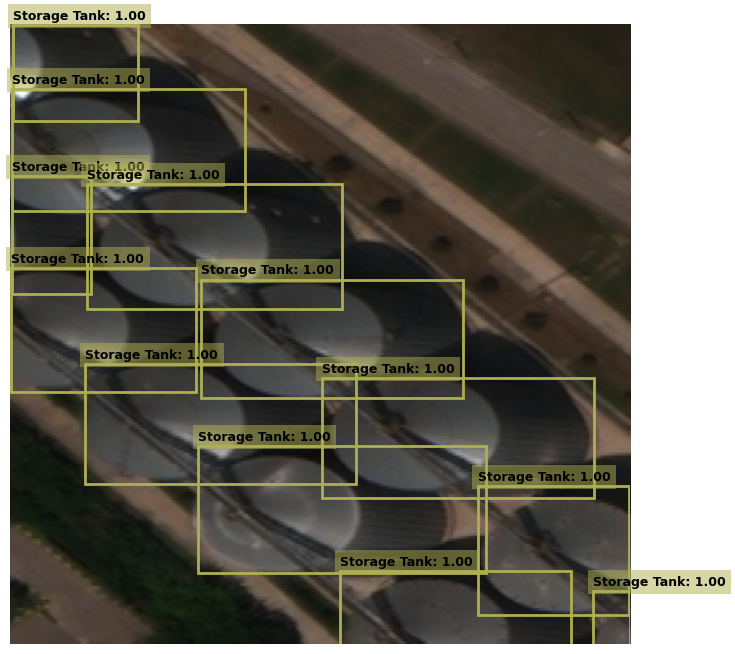

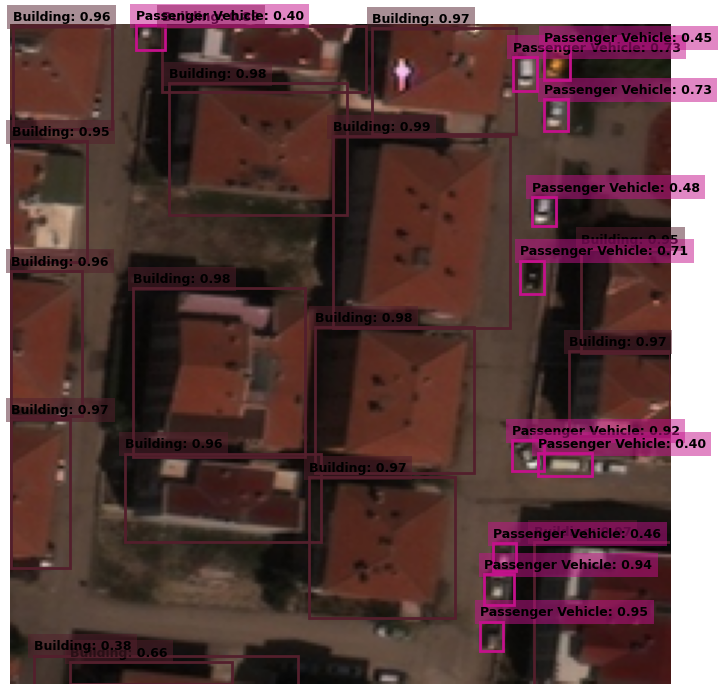

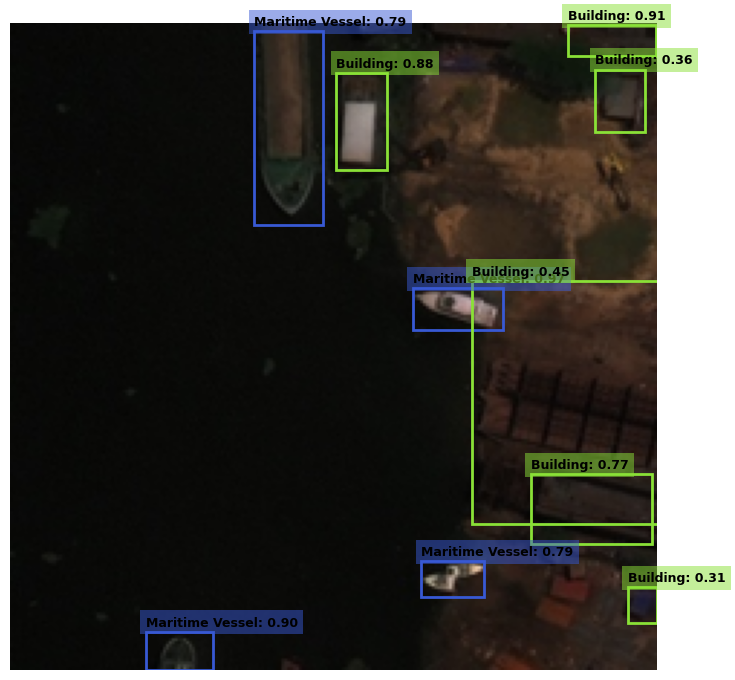

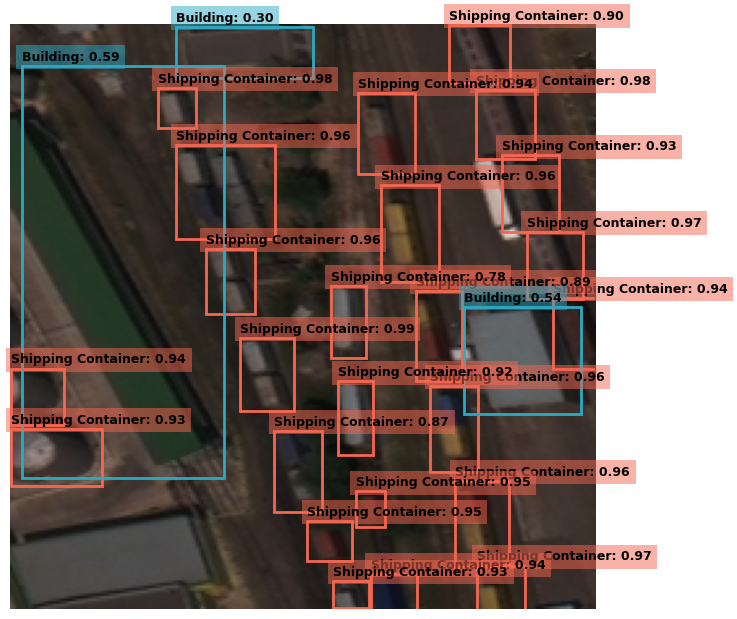

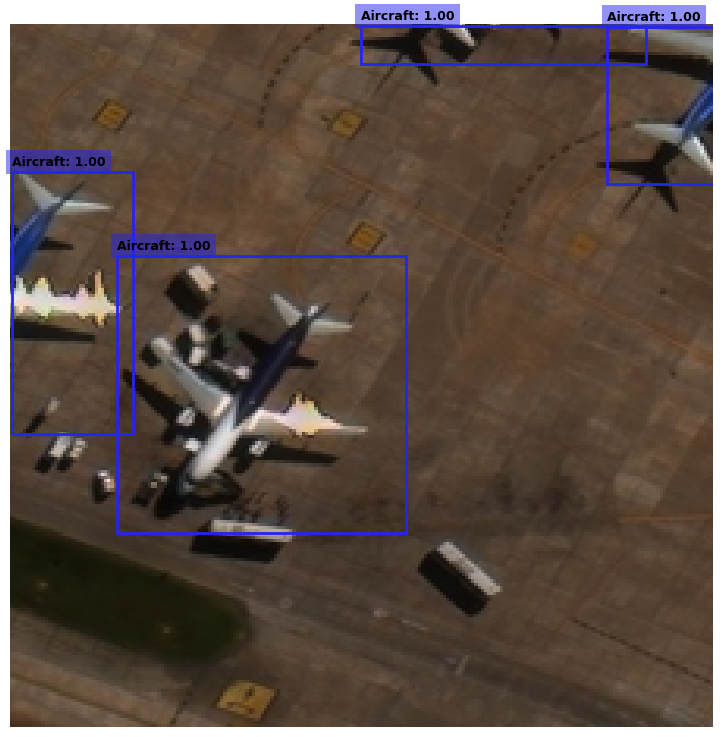

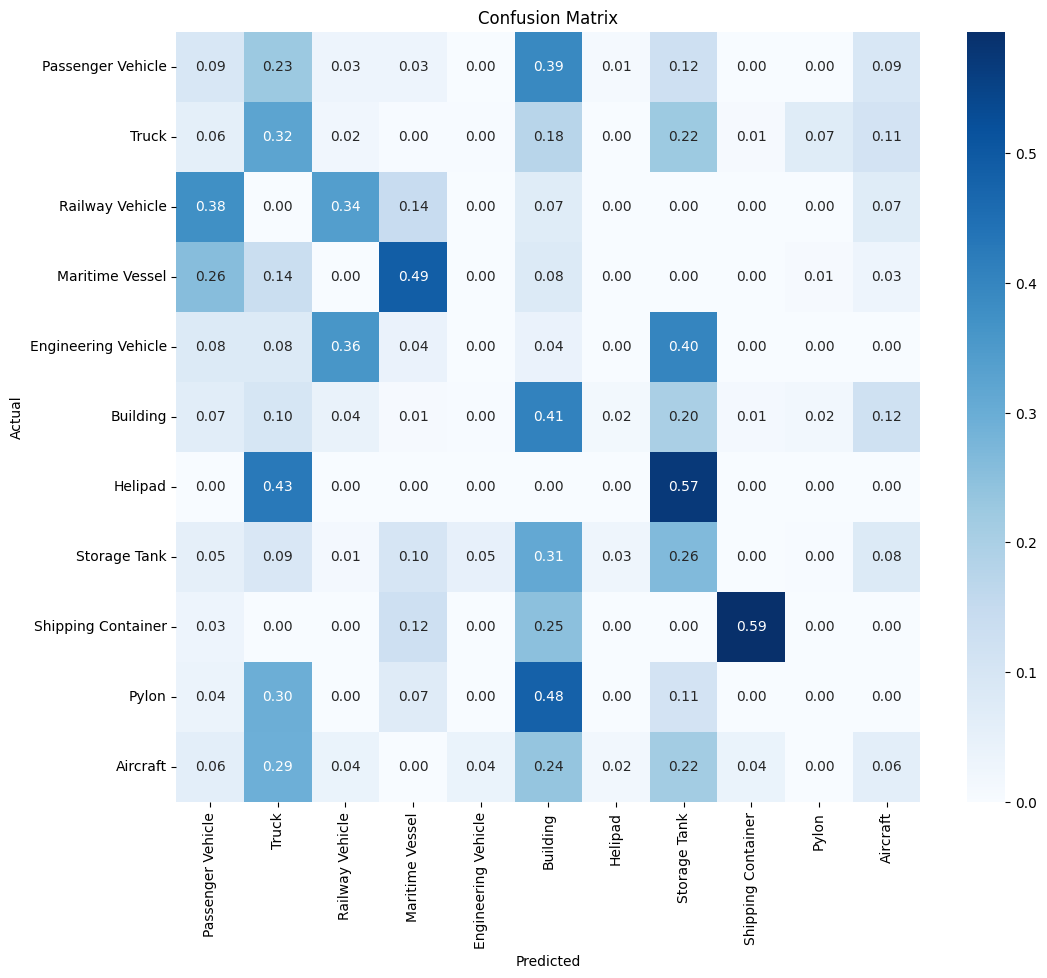

Testing completato.


In [191]:
predictions = test_model(model, test_loader, device, class_names=extract_categories_from_coco_json(new_coco_json_pth), num_classes=num_classes)

# Load CheckPoint

In [158]:
def load_pretrained_model(model_path, num_classes, device):
    """
    Carica un modello pre-addestrato e lo adatta per il fine-tuning.
    
    Args:
        model_path (str): Path al file .pth contenente i pesi salvati.
        num_classes (int): Numero di classi del nuovo dataset (incluso background).
        device (torch.device): Dispositivo per eseguire il modello.
    
    Returns:
        torch.nn.Module: Modello configurato per il fine-tuning.
    """
    # Carica il modello Faster R-CNN pre-addestrato su COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Sostituisci la testa del classificatore con una nuova per il numero di classi desiderato
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Carica i pesi salvati
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # Sposta il modello sul dispositivo specificato
    model.to(device)
    print(f"Modello caricato da {model_path} e adattato per {num_classes} classi.")
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/input/faster-rcnn/pytorch/default/1/model_epoch_8.pth"  # Path del modello salvato
num_classes = 4

# Carica il modello pre-addestrato
model = load_pretrained_model(model_path, num_classes, device)

# Fine Tuning 

In [ ]:
def fine_tune_model(model, train_loader, val_loader, optimizer, device, num_epochs=5, num_classes=12):
    """
    Esegue il fine-tuning di un modello pre-addestrato.
    """
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"\nEpoca {epoch + 1}/{num_epochs}")

        # --------------------
        # Training
        # --------------------
        model.train()
        total_train_loss = 0.0
        train_loop = tqdm(train_loader, desc="Training", leave=False)

        for i, (images, targets) in enumerate(train_loop):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.cuda.amp.autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            # Backward pass con mixed precision
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            total_train_loss += losses.item()
            train_loop.set_postfix(loss=losses.item())

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Perdita media di training: {avg_train_loss:.4f}")

        # --------------------
        # Validazione
        # --------------------
        model.eval()
        total_val_loss = 0.0
        val_loop = tqdm(val_loader, desc="Validazione", leave=False)

        with torch.no_grad():
            for images, targets in val_loop:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                with torch.cuda.amp.autocast():
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    total_val_loss += losses.item()
                    val_loop.set_postfix(loss=losses.item())

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Perdita media di validazione: {avg_val_loss:.4f}")

    print("Fine-tuning completato.")

In [ ]:
# Configurazione
num_epochs = 5
learning_rate = 0.001

# Definisci DataLoader per il nuovo dataset
train_loader = DataLoader(...)  # Sostituisci con il tuo DataLoader
val_loader = DataLoader(...)  # Sostituisci con il tuo DataLoader

# Configura l'ottimizzatore
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

# Esegui il fine-tuning
fine_tune_model(model, train_loader, val_loader, optimizer, device, num_epochs, num_classes)